Batyr Arystanbekov, Gulden Zhanmukhanbetova

# Импорт библиотек и чтение данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet

plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
data_train = pd.read_csv('train.csv')
data_train = data_train.drop(['Id', 'Province_State'], axis=1)
data_train['Date'] = pd.to_datetime(data_train['Date'])

data_test = pd.read_csv('test.csv')
data_test = data_test.drop(['ForecastId', 'Province_State'], axis=1)
data_test['Date'] = pd.to_datetime(data_test['Date'])

# Россия

Рассмотрим данные по случаям заражения и летальных исходов по Covid-19 в России.

In [ ]:
data_rus_train_init = data_train[data_train['Country_Region'] == 'Russia']
data_rus_test_init = data_test[data_test['Country_Region'] == 'Russia']
data_rus_train_init = data_rus_train_init[:-1]

data_rus_train = data_rus_train_init[~data_rus_train_init['Date'].isin(data_rus_test_init['Date'])]
data_rus_test = data_rus_train_init[data_rus_train_init['Date'].isin(data_rus_test_init['Date'])]

data_rus_train_init['Date']

23460   2020-01-22
23461   2020-01-23
23462   2020-01-24
23463   2020-01-25
23464   2020-01-26
           ...    
23569   2020-05-10
23570   2020-05-11
23571   2020-05-12
23572   2020-05-13
23573   2020-05-14
Name: Date, Length: 114, dtype: datetime64[ns]

## Полиномиальная модель

С помощью полиномиальной модели построем predict для тестовых данных. С помощью ручного перебора отыщем наилучшую степень полинома. Оценим среднюю абсолютную ошибку MAE и среднее абсолютное процентное отклонение MAPE предсказанных за тестовый период данных от фактических.

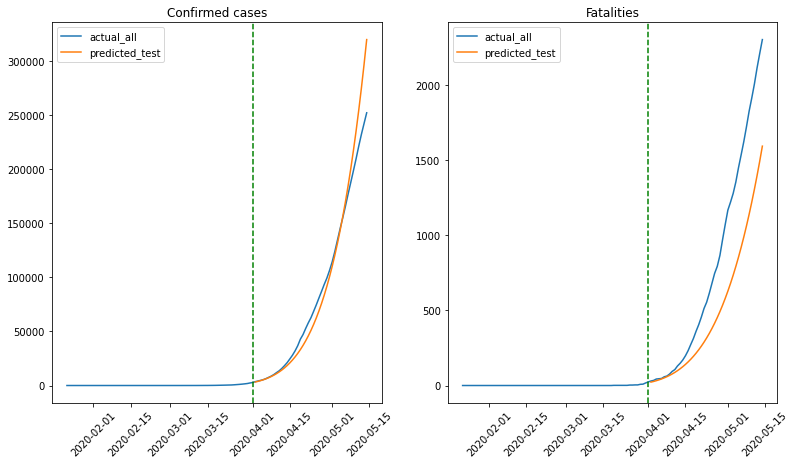

In [ ]:
n_data = len(data_rus_train_init)
n_data_train = len(data_rus_train)

# model and predictions for confirmed cases
model_conf_cases = np.polyfit(x=np.arange(n_data_train), y=data_rus_train['ConfirmedCases'], deg=6)
polynom_conf_cases = np.poly1d(model_conf_cases)
conf_cases_preds = polynom_conf_cases(np.arange(n_data_train, n_data))

# model and predictions for fatalities
model_fatals = np.polyfit(x=np.arange(n_data_train), y=data_rus_train['Fatalities'], deg=5)
polynom_fatals = np.poly1d(model_fatals)
fatals_preds = polynom_fatals(np.arange(n_data_train, n_data))

fig, axs = plt.subplots(1, 2)

fig.set_size_inches(13, 7)

axs[0].plot(data_rus_train_init['Date'], data_rus_train_init['ConfirmedCases'])
axs[0].plot(data_rus_test['Date'], conf_cases_preds)
axs[0].axvline(x=data_rus_train['Date'].values.squeeze()[n_data_train-1], color='g', linestyle='--')
axs[0].legend(['actual_all', 'predicted_test'])
axs[0].set_title('Confirmed cases')
axs[0].tick_params(axis='x', labelrotation=45)

axs[1].plot(data_rus_train_init['Date'], data_rus_train_init['Fatalities'])
axs[1].plot(data_rus_test['Date'], fatals_preds)
axs[1].axvline(x=data_rus_train['Date'].values.squeeze()[n_data_train-1], color='g', linestyle='--')
axs[1].legend(['actual_all', 'predicted_test'])
axs[1].set_title('Fatalities')
axs[1].tick_params(axis='x', labelrotation=45)

plt.show()

Расчет метрик MAP и MAPE на тестовой выборке.

In [ ]:
print('Confirmed cases predictions:')
print('MAE:', mean_absolute_error(data_rus_test['ConfirmedCases'],  conf_cases_preds))
print('MAPE:', mean_absolute_percentage_error(data_rus_test['ConfirmedCases'],  conf_cases_preds))

print(f'\nFatalities number predictions:')
print('MAE:', mean_absolute_error(data_rus_test['Fatalities'],  fatals_preds))
print('MAPE:', mean_absolute_percentage_error(data_rus_test['Fatalities'],  fatals_preds))

Confirmed cases predictions:
MAE: 10164.274170106155
MAPE: 0.11013865294344719

Fatalities number predictions:
MAE: 302.1264066609144
MAPE: 0.3323472421347533


## Выбор оптимальных степеней полиномов.

Рассмотрим более систематический подход для определения степени полинома. С помощью перебора и оценки метрики MAE найдем оптимальное значение степени.
И сравним результаты с предполагаемыми раннее степенями.

Confirmed Cases:
Best degree = 6 with MAE = 10164.274175382332

Fatalities
Best degree = 5 with MAE = 302.12640669626643


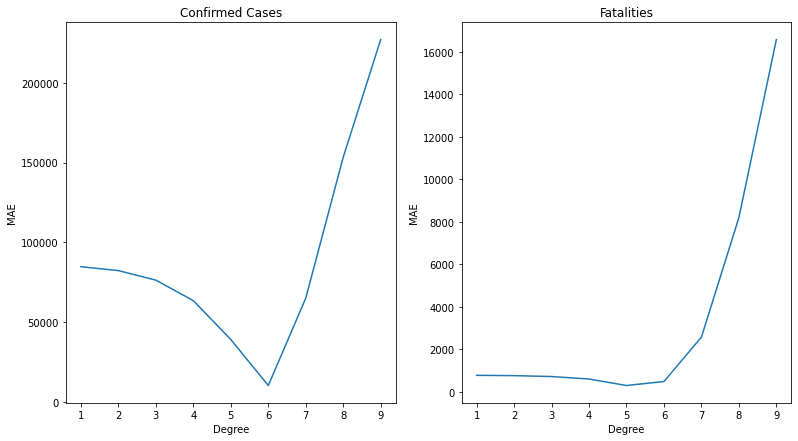

In [ ]:
deegrees = np.arange(1, 10)
min_mae = 1e10

n_data = len(data_rus_train_init)
n_data_train = len(data_rus_train)

# Linear Models for Confirmed cases
maes_conf_cases = []
best_deg_conf_cases = 0
best_mae_conf_cases = 1e10
x_train = np.arange(n_data_train).reshape(n_data_train, 1)
y_train = np.array(data_rus_train['ConfirmedCases'])
x_test = np.arange(n_data_train, n_data).reshape(n_data - n_data_train, 1)
y_test = np.array(data_rus_test['ConfirmedCases'])

for deg in deegrees:
    
    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)
    
    # Linear Regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)
    
    # Compare with test data
    x_poly_test = poly_features.transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    
    current_mae = mean_absolute_error(y_test, poly_predict)
    current_mape = mean_absolute_percentage_error(y_test, poly_predict)
    
    if current_mae < best_mae_conf_cases:
        best_mae_conf_cases = current_mae
        best_deg_conf_cases = deg
    
    maes_conf_cases.append(current_mae)
    

# Linear Models for Fatalities
maes_fatals = []
best_deg_fatals = 0
best_mae_fatals = 1e10
x_train = np.arange(n_data_train).reshape(n_data_train, 1)
y_train = np.array(data_rus_train['Fatalities'])
x_test = np.arange(n_data_train, n_data).reshape(n_data - n_data_train, 1)
y_test = np.array(data_rus_test['Fatalities'])

for deg in deegrees:
    
    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)
    
    # Linear Regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)
    
    # Compare with test data
    x_poly_test = poly_features.transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    
    current_mae = mean_absolute_error(y_test, poly_predict)
    current_mape = mean_absolute_percentage_error(y_test, poly_predict)
        
    if current_mae < best_mae_fatals:
        best_mae_fatals = current_mae
        best_deg_fatals = deg
        
    maes_fatals.append(current_mae)

    
print('Confirmed Cases:')
print('Best degree =', best_deg_conf_cases, 'with MAE =', best_mae_conf_cases)

print(f'\nFatalities')
print('Best degree =', best_deg_fatals, 'with MAE =', best_mae_fatals)
    
fig, axs = plt.subplots(1, 2)

fig.set_size_inches(13, 7)

axs[0].plot(deegrees, maes_conf_cases)
axs[0].set_title('Confirmed Cases')
axs[1].plot(deegrees, maes_fatals)
axs[1].set_title('Fatalities')

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='MAE')

plt.show()

## ARIMA

### Confirmed Cases

In [ ]:
def adf_test(data):
    test = adfuller(data)
    print('ADF:', test[0])
    print('p-value:', test[1])
    print('Critical values:', test[4])
    if test[0] > test[4]['5%']:
        print('Есть единичные корни, ряд не стационарен')
    else:
        print('Единичных корней нет, ряд стационарен')
    print()

In [ ]:
print('Исходный ряд:')
adf_test(data_rus_train['ConfirmedCases'])

print('Ряд за вычетом тренда')
trend = pd.DataFrame(data=(data_rus_train['ConfirmedCases'] - polynom_conf_cases(np.arange(n_data_train))))
adf_test(trend.values.squeeze())

print('d = 0')

Исходный ряд:
ADF: 0.9514593064433754
p-value: 0.9937264446728314
Critical values: {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
Есть единичные корни, ряд не стационарен

Ряд за вычетом тренда
ADF: -3.4928479286071585
p-value: 0.008172685497607893
Critical values: {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
Единичных корней нет, ряд стационарен

d = 0


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 7.5 MB/s 
     |████████████████████████████████| 9.8 MB 48.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.arima import ndiffs
ndiffs(trend.values.squeeze())

0

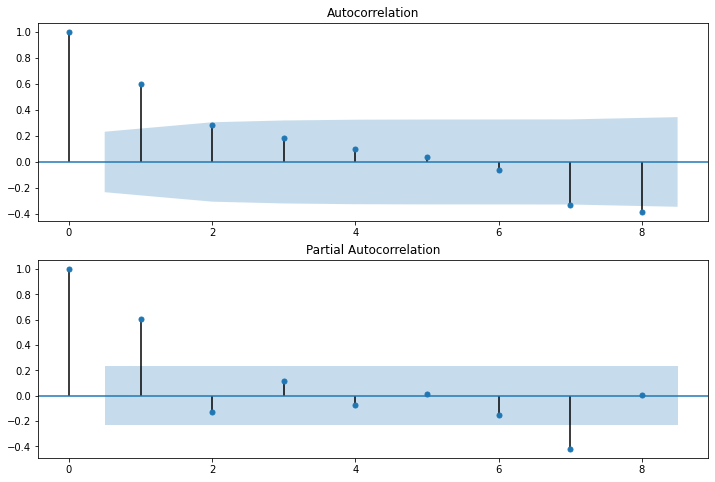

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
fig = plot_acf(trend.values.squeeze(), lags=8, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(trend.values.squeeze(), lags=8, ax=ax2)

p = 1, q = 1

In [ ]:
model = ARIMA(trend.values, order=(1, 0, 1))
result = model.fit()

print(result.summary())

preds = result.predict(0, n_data-1)
init_preds = preds + polynom_conf_cases(np.arange(n_data))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   71
Model:                     ARMA(1, 1)   Log Likelihood                -297.586
Method:                       css-mle   S.D. of innovations             15.933
Date:                Wed, 22 Dec 2021   AIC                            603.172
Time:                        18:15:50   BIC                            612.223
Sample:                             0   HQIC                           606.771
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1259      4.859      0.026      0.979      -9.397       9.648
ar.L1.y        0.5557      0.169      3.294      0.002       0.225       0.886
ma.L1.y        0.1617      0.192      0.844      0.4

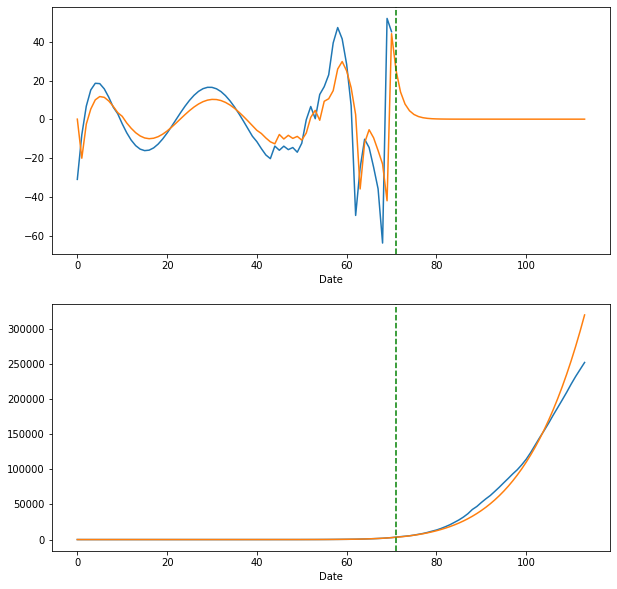

In [ ]:
fig, axs = plt.subplots(2, 1)

fig.set_size_inches(10, 10)

axs[0].plot(trend.values.squeeze())
axs[0].plot(preds)
axs[0].axvline(x=n_data_train, color='g', linestyle='--')

axs[1].plot(data_rus_train_init['ConfirmedCases'].values.squeeze())
axs[1].plot(init_preds)
axs[1].axvline(x=n_data_train, color='g', linestyle='--')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='')

plt.show()

In [ ]:
print('Confirmed cases predictions:')
print('MAE:', mean_absolute_error(data_rus_train_init['ConfirmedCases'].values.squeeze()[n_data_train:n_data], init_preds[n_data_train:n_data]))
print('MAPE:', mean_absolute_percentage_error(data_rus_train_init['ConfirmedCases'].values.squeeze()[n_data_train:n_data], init_preds[n_data_train:n_data]))

Confirmed cases predictions:
MAE: 10162.885194326085
MAPE: 0.1098147055389256


### Fatalities

In [ ]:
trend = pd.DataFrame(data=(data_rus_train['Fatalities'] - polynom_fatals(np.arange(n_data_train))))
ndiffs(trend.values.squeeze())

0

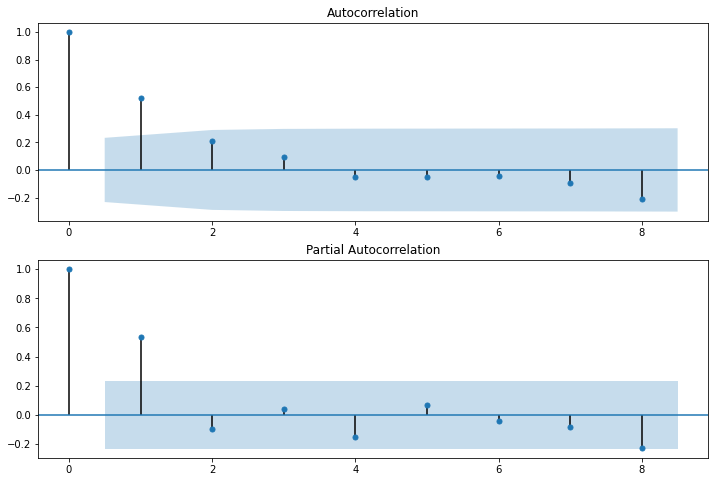

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
fig = plot_acf(trend.values.squeeze(), lags=8, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(trend.values.squeeze(), lags=8, ax=ax2)

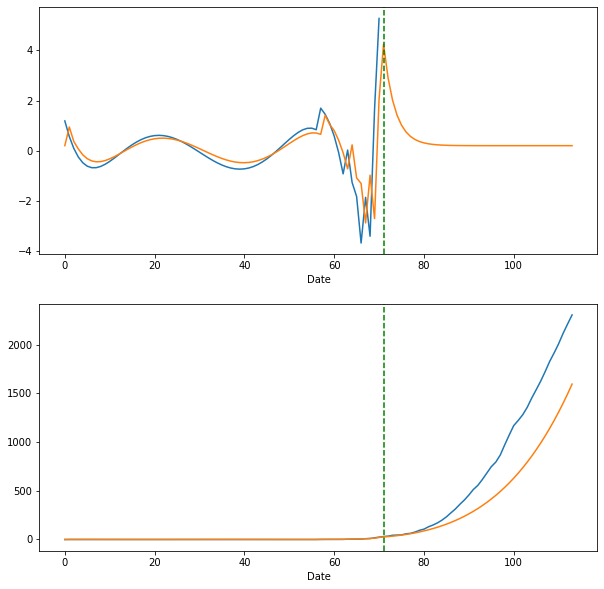

In [ ]:
model = ARIMA(trend.values, order=(1, 0, 1))
result = model.fit()

preds = result.predict(0, n_data-1)
init_preds = preds + polynom_fatals(np.arange(n_data))

fig, axs = plt.subplots(2, 1)

fig.set_size_inches(10, 10)

axs[0].plot(trend.values.squeeze())
axs[0].plot(preds)
axs[0].axvline(x=n_data_train, color='g', linestyle='--')

axs[1].plot(data_rus_train_init['Fatalities'].values.squeeze())
axs[1].plot(init_preds)
axs[1].axvline(x=n_data_train, color='g', linestyle='--')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='')

plt.show()

In [ ]:
print('Fatalities number predictions:')
print('MAE:', mean_absolute_error(data_rus_train_init['Fatalities'].values.squeeze()[n_data_train:n_data], init_preds[n_data_train:n_data]))
print('MAPE:', mean_absolute_percentage_error(data_rus_train_init['Fatalities'].values.squeeze()[n_data_train:n_data], init_preds[n_data_train:n_data]))

Fatalities number predictions:
MAE: 301.63521059637213
MAPE: 0.3235748017216708


## Prophet

In [ ]:
data_conf_cases_train = pd.DataFrame({'ds': data_rus_train['Date'], 'y': data_rus_train['ConfirmedCases']})
data_conf_cases_train.head()

,ds,y
23460,2020-01-22,0.0
23461,2020-01-23,0.0
23462,2020-01-24,0.0
23463,2020-01-25,0.0
23464,2020-01-26,0.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


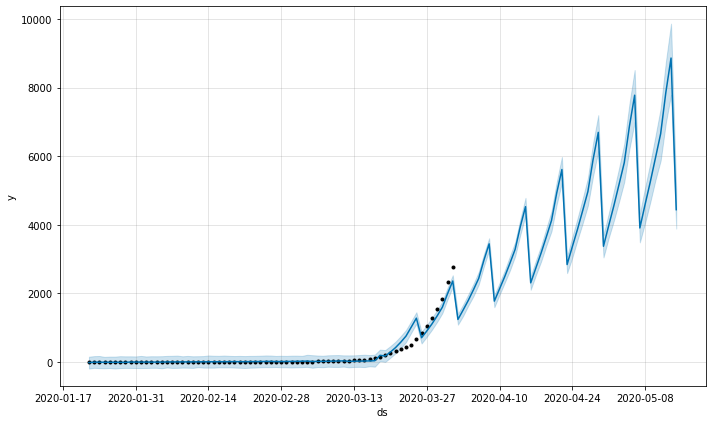

In [ ]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(data_conf_cases_train)

future = model.make_future_dataframe(periods=n_data-n_data_train, freq='d')
forecast = model.predict(future)
model.plot(forecast);

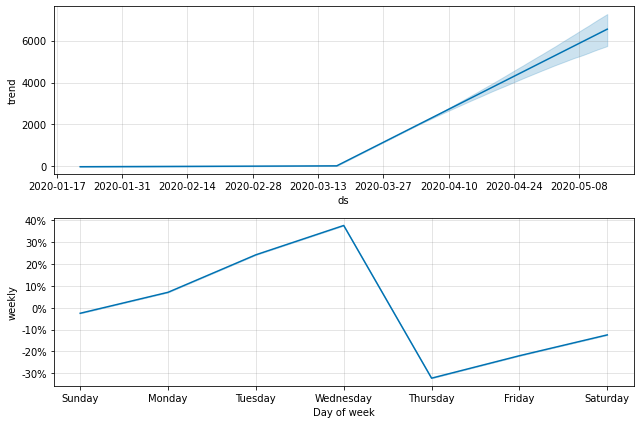

In [ ]:
model.plot_components(forecast);